In [1]:
import cv2
import numpy as np
from org_ir import *
import matplotlib.pyplot as plt

In [2]:
filepath = r'../IrisDB/test-data/Test/S2005R09.jpg'
show = False

In [8]:

def copy_rois(rois1):
    return {
        'right-side': {
            'img': rois1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois1['complete']['kp']],
            'des': rois1['complete']['des'].copy(),
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'left-side': {
            'img': rois1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois1['complete']['kp']],
            'des': rois1['complete']['des'].copy(),
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'bottom': {
            'img': rois1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois1['complete']['kp']],
            'des': rois1['complete']['des'].copy(),
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'complete': {
            'img': rois1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois1['complete']['kp']],
            'des': rois1['complete']['des'].copy(),
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        }
    }

def copy_rois_early(rois1):
    return {
        'right-side': {
            'img': rois1['complete']['img'],
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'left-side': {
            'img': rois1['complete']['img'],
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'bottom': {
            'img': rois1['complete']['img'],
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        },
        'complete': {
            'img': rois1['complete']['img'],
            'pupil_circle': rois1['complete']['pupil_circle'],
            'ext_circle': rois1['complete']['ext_circle'],
        }
    }  

In [4]:
def histogram(float_list):
    plt.figure(figsize=(10, 6))
    plt.hist(float_list, bins=50, color='skyblue', edgecolor='black')

    # Add title and labels
    plt.title('Histogram of Float Values')
    plt.xlabel('Value Range')
    plt.ylabel('Frequency')

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.show()

In [54]:
def custom_load_keypoints(sift, rois_a, show=False):
    bf = cv2.BFMatcher()


    for pos in ['right-side','left-side','bottom','complete']:
        kp_init = list(sift.detect(rois_a[pos]['img'],None))
        
        size = []
        for keypoint in list(kp_init):
            size.append(float(keypoint.size))
        print(f"for {pos}:\n  len: {len(size)}")        

        rois_a[pos]['img_kp_init'] = cv2.drawKeypoints(
                                        rois_a[pos]['img'], kp_init,
                                        color=(0,255,0), flags=0,
                                        outImage=None)
        # cv2.imshow(f"rois_a['{pos}']['img_kp_init'] After", rois_a[pos]['img_kp_init'])
        cv2.circle(
            rois_a[pos]['img_kp_init'],
            (rois_a[pos]['pupil_circle'][0], rois_a[pos]['pupil_circle'][1]),
            rois_a[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois_a[pos]['img_kp_init'],
            (rois_a[pos]['ext_circle'][0], rois_a[pos]['ext_circle'][1]),
            rois_a[pos]['ext_circle'][2], (0,255,255), 1)

        # Filter detected keypoints
        inside = 0
        outside = 0
        wrong_angle = 0
        kp_size_not = 0
        removed_sizes = []
        before_len = len(kp_init)
        if pos == 'complete' : rois_a['kp_len'] = len(kp_init)
        for kp in kp_init:
            c_angle = angle_v(rois_a[pos]['ext_circle'][0],
                              rois_a[pos]['ext_circle'][1],
                              kp.pt[0], kp.pt[1])
            if point_in_circle(rois_a[pos]['pupil_circle'][0],
                               rois_a[pos]['pupil_circle'][1],
                               rois_a[pos]['pupil_circle'][2]+3,
                               kp.pt[0], kp.pt[1]):
                kp_init.remove(kp)
                inside +=1
            elif not point_in_circle(rois_a[pos]['ext_circle'][0],
                                     rois_a[pos]['ext_circle'][1],
                                     rois_a[pos]['ext_circle'][2]-5,
                                     kp.pt[0], kp.pt[1]):
                kp_init.remove(kp)
                outside +=1
            elif (pos == 'right-side' and (c_angle <= -45 or c_angle >= 45)) or \
                 (pos == 'left-side' and (c_angle <= 135 and c_angle >= -135)) or \
                 (pos == 'bottom' and (c_angle <= -135 or c_angle >= -45)):
                kp_init.remove(kp)
                wrong_angle +=1
            if float(kp.size) > 0 and kp in kp_init : kp_init.remove(kp);kp_size_not+=1;removed_sizes.append(float(kp.size))
            else: print(float(kp.size))
        rois_a[pos]['kp'] = tuple(kp_init)
        
        print(f"{kp_size_not=}, {inside=}, {outside=}, {wrong_angle=}, total={before_len} - {kp_size_not+inside+outside+wrong_angle}")
        
        size = []
        for keypoint in list(rois_a[pos]['kp'][:]):
            size.append(float(keypoint.size))
        print(f"\nfor {pos}:\n  len: {len(size)}\n  avg: {sum(size)/len(size)}\n  max: {max(size)}\n  min: {min(size)}")
        histogram(size)
        print(removed_sizes)
        
        if pos == 'complete' : rois_a['kp_filtered_len'] = len(rois_a[pos]['kp'])

        # Create images with filtered keypoints
        rois_a[pos]['img_kp_filtered'] = cv2.drawKeypoints(
                                rois_a[pos]['img'],rois_a[pos]['kp'],
                                color=(0,255,0), flags=0,
                                outImage=None)
        cv2.circle(
            rois_a[pos]['img_kp_filtered'],
            (rois_a[pos]['pupil_circle'][0],rois_a[pos]['pupil_circle'][1]),
            rois_a[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois_a[pos]['img_kp_filtered'],
            (rois_a[pos]['ext_circle'][0],rois_a[pos]['ext_circle'][1]),
            rois_a[pos]['ext_circle'][2], (0,255,255), 1)

    # Show keypoints images
    if show:
        i=0
        for pos in ['right-side','left-side','bottom']:
            plt.subplot(3, 2, 2*i+1), \
            plt.imshow(rois_a[pos]['img_kp_init'])
            plt.xticks([]), plt.yticks([])
            plt.subplot(3, 2, 2*i+2), \
            plt.imshow(rois_a[pos]['img_kp_filtered'])
            plt.xticks([]), plt.yticks([])
            i+=1
        plt.show()

def custom_load_descriptors(sift, rois_a):
    for pos in ['right-side','left-side','bottom','complete']:
        rois_a[pos]['kp'], rois_a[pos]['des'] = \
            sift.compute( rois_a[pos]['img'], rois_a[pos]['kp'] )
    rois_a['desc_len'] = len(rois_a['complete']['des'])
    rois_a['kp_desc_len'] = len(rois_a['complete']['kp'])
        # cv2.imshow(f"rois_a[{pos}]['des']", rois_a[pos]['des'])
        # print(rois_a[pos]['des'][0:2])



Image loaded -> ['test-data', 'Test', 'S2005R09.jpg']
Getting iris boundaries ...
Equalizing histogram ...
Getting roi iris images ...
Showing only sides grey images...


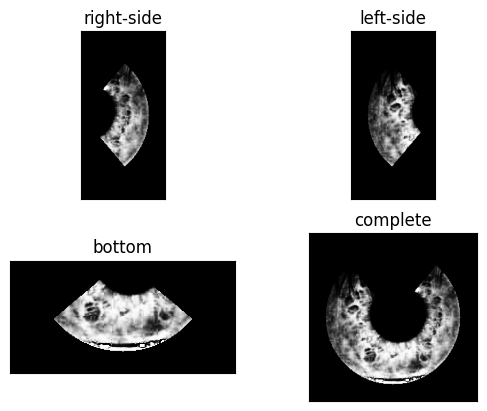

In [6]:
img = load_image(filepath, show) # show=True
print(f"\nImage loaded -> {(filepath.split('/'))[-3:]}")

print(f"Getting iris boundaries ...")
pupil_circle, ext_iris_circle = get_iris_boundaries(img, show=show) # Getting iris boundaries includes outer and inner boundary.
if not pupil_circle or not ext_iris_circle:
    print("Error finding iris boundaries!")

print("Equalizing histogram ...")
roi = get_equalized_iris(img, ext_iris_circle, pupil_circle, show=show)

print("Getting roi iris images ...")
rois = get_rois(roi, pupil_circle, ext_iris_circle, show=show)


In [64]:
rois1 = copy_rois_early(rois)
rois1['complete'].keys()

dict_keys(['img', 'pupil_circle', 'ext_circle'])

Searching for keypoints ...
for right-side:
  len: 415
kp_size_not=208, inside=0, outside=0, wrong_angle=0, total=415 - 208

for right-side:
  len: 207
  avg: 3.8753593060129505
  max: 44.59374237060547
  min: 1.8002351522445679


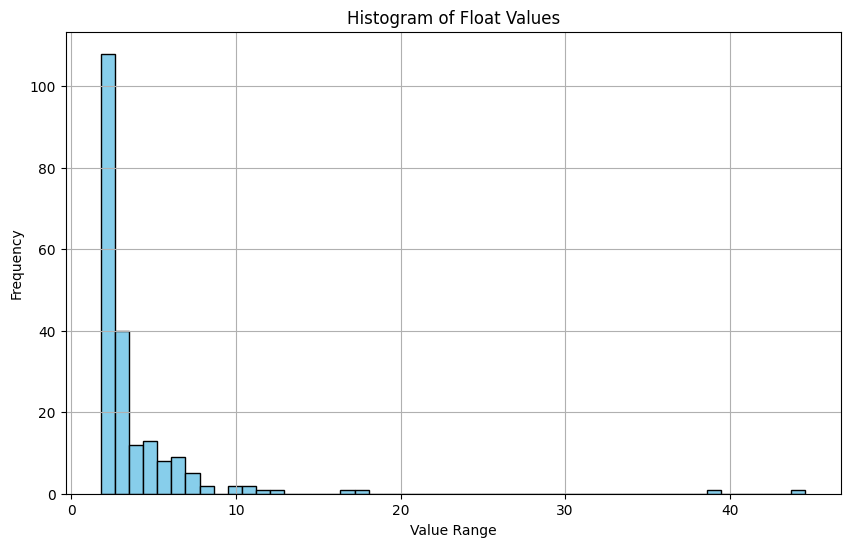

[1.872353196144104, 1.8555465936660767, 2.205183982849121, 4.715872287750244, 3.3350231647491455, 2.679718017578125, 2.147118330001831, 4.771503448486328, 3.052198886871338, 1.8696813583374023, 2.336322546005249, 2.8327949047088623, 2.727980375289917, 5.606795310974121, 1.968584418296814, 2.198378801345825, 2.5386974811553955, 2.7006969451904297, 3.0351569652557373, 6.0607590675354, 2.1098926067352295, 1.8702419996261597, 6.099362850189209, 2.5808074474334717, 3.1974313259124756, 1.8244549036026, 3.3753888607025146, 4.565709590911865, 2.047001361846924, 6.121627330780029, 4.40857458114624, 3.5501956939697266, 3.2306172847747803, 1.9147909879684448, 2.6586101055145264, 2.036170721054077, 2.1674489974975586, 2.0795466899871826, 3.849567413330078, 2.9415767192840576, 6.418135166168213, 6.107969284057617, 4.208774566650391, 2.0507075786590576, 2.3797261714935303, 6.620323181152344, 7.208195686340332, 2.074256181716919, 2.108027219772339, 1.9050449132919312, 2.1993095874786377, 2.1539309024

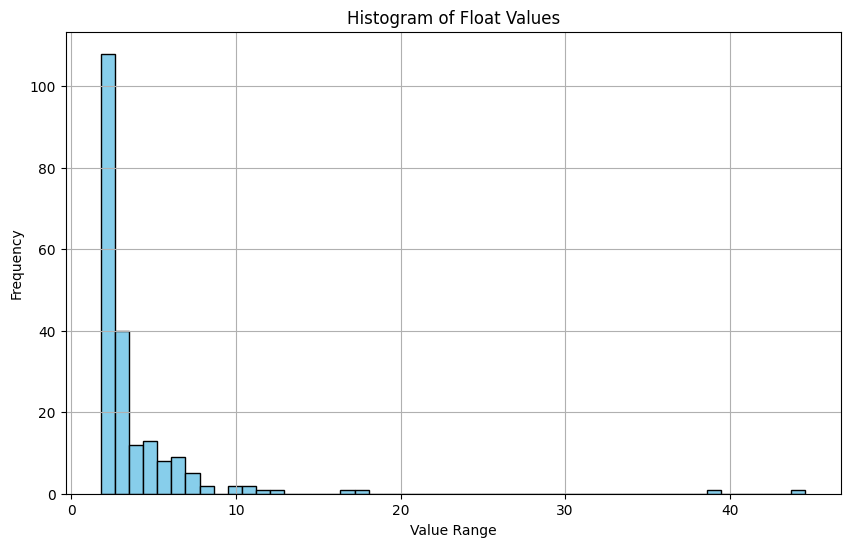

[1.872353196144104, 1.8555465936660767, 2.205183982849121, 4.715872287750244, 3.3350231647491455, 2.679718017578125, 2.147118330001831, 4.771503448486328, 3.052198886871338, 1.8696813583374023, 2.336322546005249, 2.8327949047088623, 2.727980375289917, 5.606795310974121, 1.968584418296814, 2.198378801345825, 2.5386974811553955, 2.7006969451904297, 3.0351569652557373, 6.0607590675354, 2.1098926067352295, 1.8702419996261597, 6.099362850189209, 2.5808074474334717, 3.1974313259124756, 1.8244549036026, 3.3753888607025146, 4.565709590911865, 2.047001361846924, 6.121627330780029, 4.40857458114624, 3.5501956939697266, 3.2306172847747803, 1.9147909879684448, 2.6586101055145264, 2.036170721054077, 2.1674489974975586, 2.0795466899871826, 3.849567413330078, 2.9415767192840576, 6.418135166168213, 6.107969284057617, 4.208774566650391, 2.0507075786590576, 2.3797261714935303, 6.620323181152344, 7.208195686340332, 2.074256181716919, 2.108027219772339, 1.9050449132919312, 2.1993095874786377, 2.1539309024

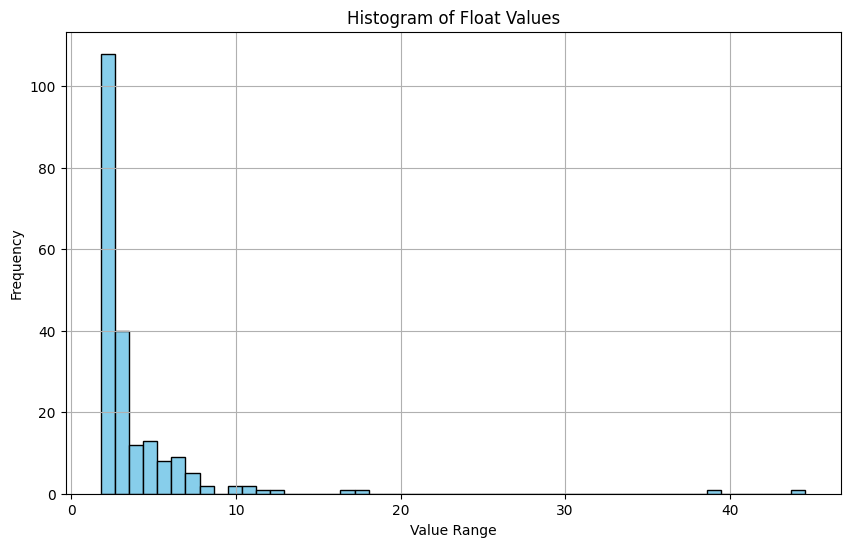

[1.872353196144104, 1.8555465936660767, 2.205183982849121, 4.715872287750244, 3.3350231647491455, 2.679718017578125, 2.147118330001831, 4.771503448486328, 3.052198886871338, 1.8696813583374023, 2.336322546005249, 2.8327949047088623, 2.727980375289917, 5.606795310974121, 1.968584418296814, 2.198378801345825, 2.5386974811553955, 2.7006969451904297, 3.0351569652557373, 6.0607590675354, 2.1098926067352295, 1.8702419996261597, 6.099362850189209, 2.5808074474334717, 3.1974313259124756, 1.8244549036026, 3.3753888607025146, 4.565709590911865, 2.047001361846924, 6.121627330780029, 4.40857458114624, 3.5501956939697266, 3.2306172847747803, 1.9147909879684448, 2.6586101055145264, 2.036170721054077, 2.1674489974975586, 2.0795466899871826, 3.849567413330078, 2.9415767192840576, 6.418135166168213, 6.107969284057617, 4.208774566650391, 2.0507075786590576, 2.3797261714935303, 6.620323181152344, 7.208195686340332, 2.074256181716919, 2.108027219772339, 1.9050449132919312, 2.1993095874786377, 2.1539309024

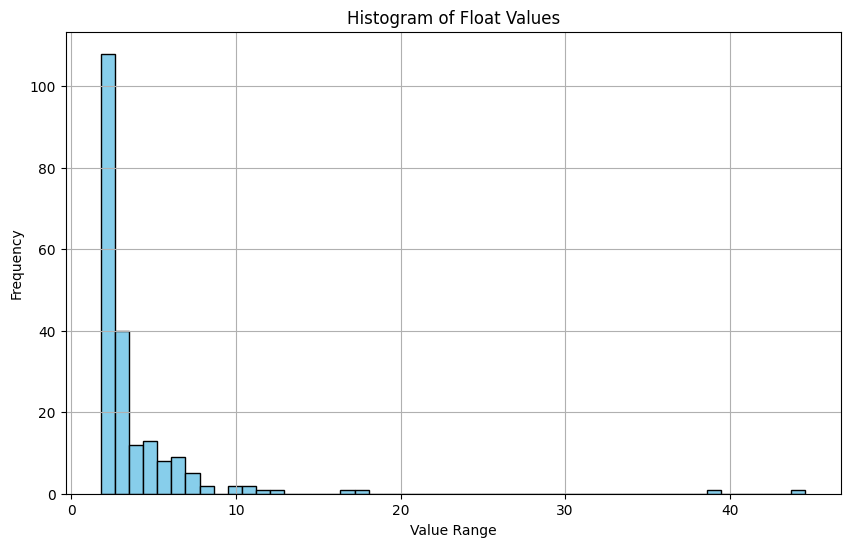

[1.872353196144104, 1.8555465936660767, 2.205183982849121, 4.715872287750244, 3.3350231647491455, 2.679718017578125, 2.147118330001831, 4.771503448486328, 3.052198886871338, 1.8696813583374023, 2.336322546005249, 2.8327949047088623, 2.727980375289917, 5.606795310974121, 1.968584418296814, 2.198378801345825, 2.5386974811553955, 2.7006969451904297, 3.0351569652557373, 6.0607590675354, 2.1098926067352295, 1.8702419996261597, 6.099362850189209, 2.5808074474334717, 3.1974313259124756, 1.8244549036026, 3.3753888607025146, 4.565709590911865, 2.047001361846924, 6.121627330780029, 4.40857458114624, 3.5501956939697266, 3.2306172847747803, 1.9147909879684448, 2.6586101055145264, 2.036170721054077, 2.1674489974975586, 2.0795466899871826, 3.849567413330078, 2.9415767192840576, 6.418135166168213, 6.107969284057617, 4.208774566650391, 2.0507075786590576, 2.3797261714935303, 6.620323181152344, 7.208195686340332, 2.074256181716919, 2.108027219772339, 1.9050449132919312, 2.1993095874786377, 2.1539309024

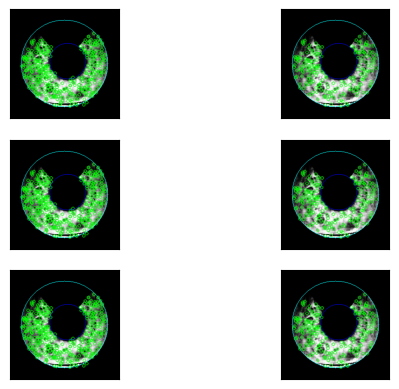

Rois completed for S2005R09.


In [65]:
print("Searching for keypoints ...")
sift = cv2.SIFT_create()
custom_load_keypoints(sift, rois1, show=show)
custom_load_descriptors(sift, rois1)

print(f"Rois completed for {(filepath.split('/'))[-1].replace('.jpg', '')}.")

In [ ]:
print(rois1['right-side']['kp'])